# Clustering

## Imports and connections

In [95]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans, DBSCAN, OPTICS, AgglomerativeClustering
from sklearn.metrics import silhouette_score, calinski_harabasz_score, davies_bouldin_score
from scipy.spatial.distance import cdist
from scipy.cluster.hierarchy import dendrogram, linkage

In [96]:
RANDOM_STATE = 2004

## Data load

In [97]:
df = sns.load_dataset('penguins')

In [98]:
df

,species,island,bill_length_mm,bill_depth_mm,flipper_length_mm,body_mass_g,sex
0,Adelie,Torgersen,39.1,18.7,181.0,3750.0,Male
1,Adelie,Torgersen,39.5,17.4,186.0,3800.0,Female
2,Adelie,Torgersen,40.3,18.0,195.0,3250.0,Female
3,Adelie,Torgersen,NaN,NaN,NaN,NaN,NaN
4,Adelie,Torgersen,36.7,19.3,193.0,3450.0,Female
...,...,...,...,...,...,...,...
339,Gentoo,Biscoe,NaN,NaN,NaN,NaN,NaN
340,Gentoo,Biscoe,46.8,14.3,215.0,4850.0,Female
341,Gentoo,Biscoe,50.4,15.7,222.0,5750.0,Male
342,Gentoo,Biscoe,45.2,14.8,212.0,5200.0,Female


## DA

- species (object): Вид пингвина (Adelie, Chinstrap, Gentoo).
- island (object): Остров обитания (Biscoe, Dream, Torgersen).
- bill_length_mm (float64): Длина клюва в миллиметрах.
- bill_depth_mm (float64): Глубина клюва в миллиметрах.
- flipper_length_mm (float64): Длина плавника в миллиметрах.
- body_mass_g (float64): Масса тела в граммах.
- sex (object): Пол пингвина (Male, Female).

In [99]:
df = df.dropna()

In [100]:
df_num = df.drop(['species', 'sex', 'island'], axis=1)
y = df['species']

In [101]:
df.describe()

,bill_length_mm,bill_depth_mm,flipper_length_mm,body_mass_g
count,333.000000,333.000000,333.000000,333.000000
mean,43.992793,17.164865,200.966967,4207.057057
std,5.468668,1.969235,14.015765,805.215802
min,32.100000,13.100000,172.000000,2700.000000
25%,39.500000,15.600000,190.000000,3550.000000
50%,44.500000,17.300000,197.000000,4050.000000
75%,48.600000,18.700000,213.000000,4775.000000
max,59.600000,21.500000,231.000000,6300.000000


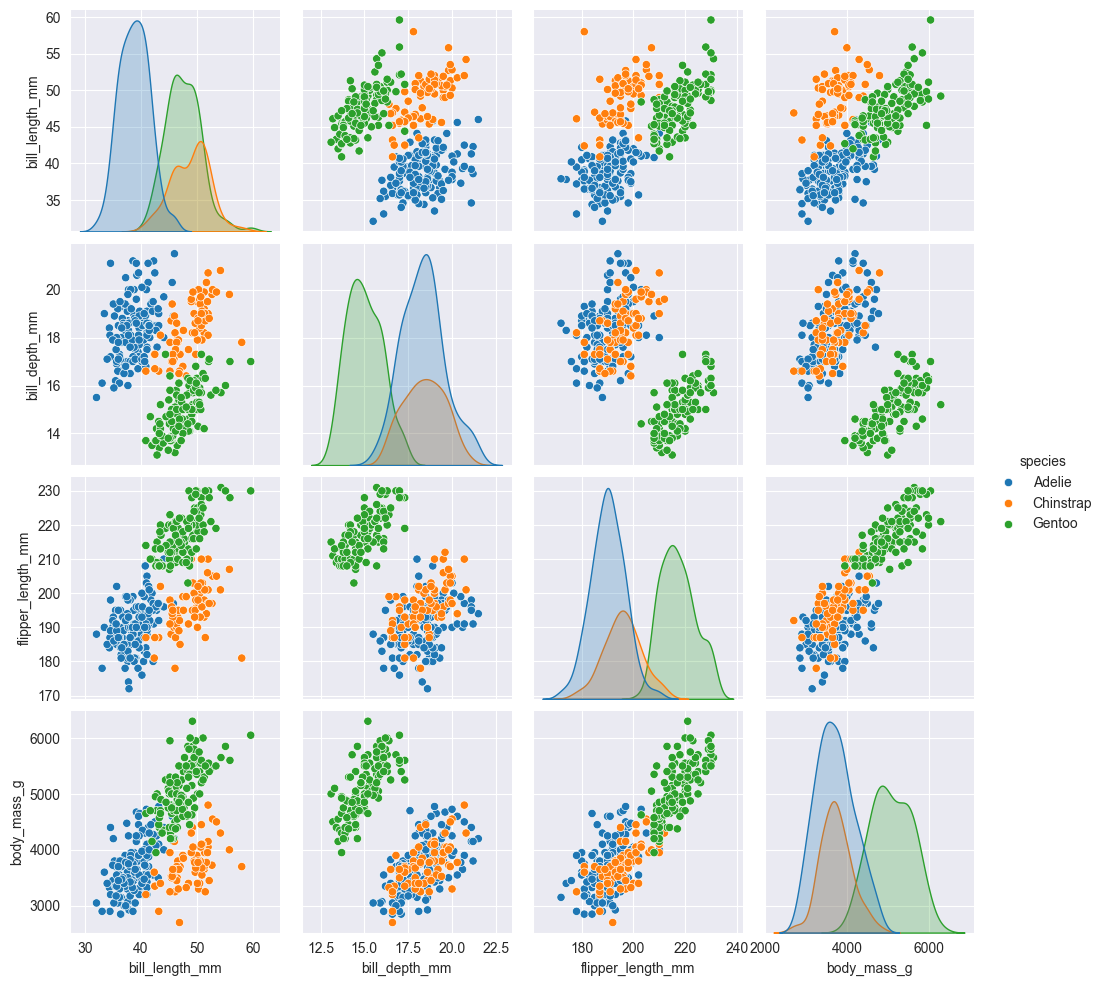

In [102]:
sns.pairplot(df, hue='species', vars=df_num.columns)
plt.show()

## Methods

In [103]:
X = StandardScaler().fit_transform(df_num.values)

### K-Means

#### Analytical

In [104]:
def kmeans_analytical(X, k, max_iter=1000, random_state=None):
    np.random.seed(random_state)
    idx = np.random.choice(len(X), k, replace=False)
    centroids = X[idx]

    for _ in range(max_iter):
        distances = cdist(X, centroids)
        labels = np.argmin(distances, axis=1)

        new_centroids = np.array([X[labels == i].mean(axis=0) for i in range(k)])

        if np.allclose(centroids, new_centroids):
            break
        centroids = new_centroids

    return labels, centroids

In [105]:
labels_km_analytical, centroids_analytical = kmeans_analytical(X, k=3)

#### Lib

In [106]:
km = KMeans(n_clusters=3, random_state=RANDOM_STATE)
labels_km_lib = km.fit_predict(X)
centroids_lib = km.cluster_centers_

### Метод локтя

In [107]:
def compute_elbow(X, max_k=10):
    wcss = []
    for k in range(1, max_k + 1):
        labels, centroids = kmeans_analytical(X, k)
        wcss.append(sum(np.min(cdist(X, centroids), axis=1) ** 2))
    return wcss

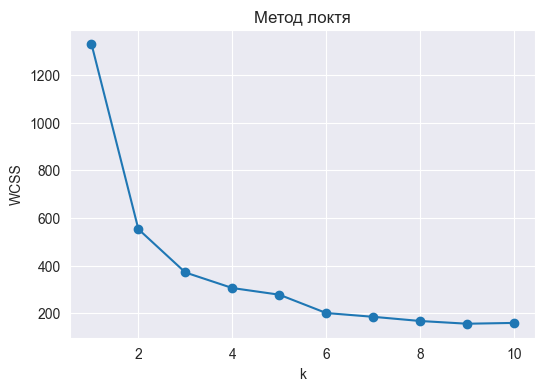

In [108]:
wcss = compute_elbow(X, max_k=10)
plt.figure(figsize=(6, 4))
plt.plot(range(1, 11), wcss, marker="o")
plt.title("Метод локтя")
plt.xlabel("k")
plt.ylabel("WCSS")
plt.show()

### DSCAN

In [109]:
dbscan = DBSCAN(eps=0.7, min_samples=2).fit(X)
labels_db = dbscan.labels_

In [110]:
n_clusters_dbscan = len(set(labels_db) - {-1})
n_clusters_dbscan

3

### OPTICS

In [111]:
optics = OPTICS(max_eps=0.7, min_samples=6).fit(X)
labels_opt = optics.labels_

In [112]:
n_clusters_optics = len(set(labels_opt) - {-1})
n_clusters_optics

5

### Иерархический метод(Метод Уорда)

In [113]:
agg = AgglomerativeClustering(n_clusters=3, linkage='ward')
labels_hier = agg.fit_predict(X)

<Figure size 600x400 with 0 Axes>

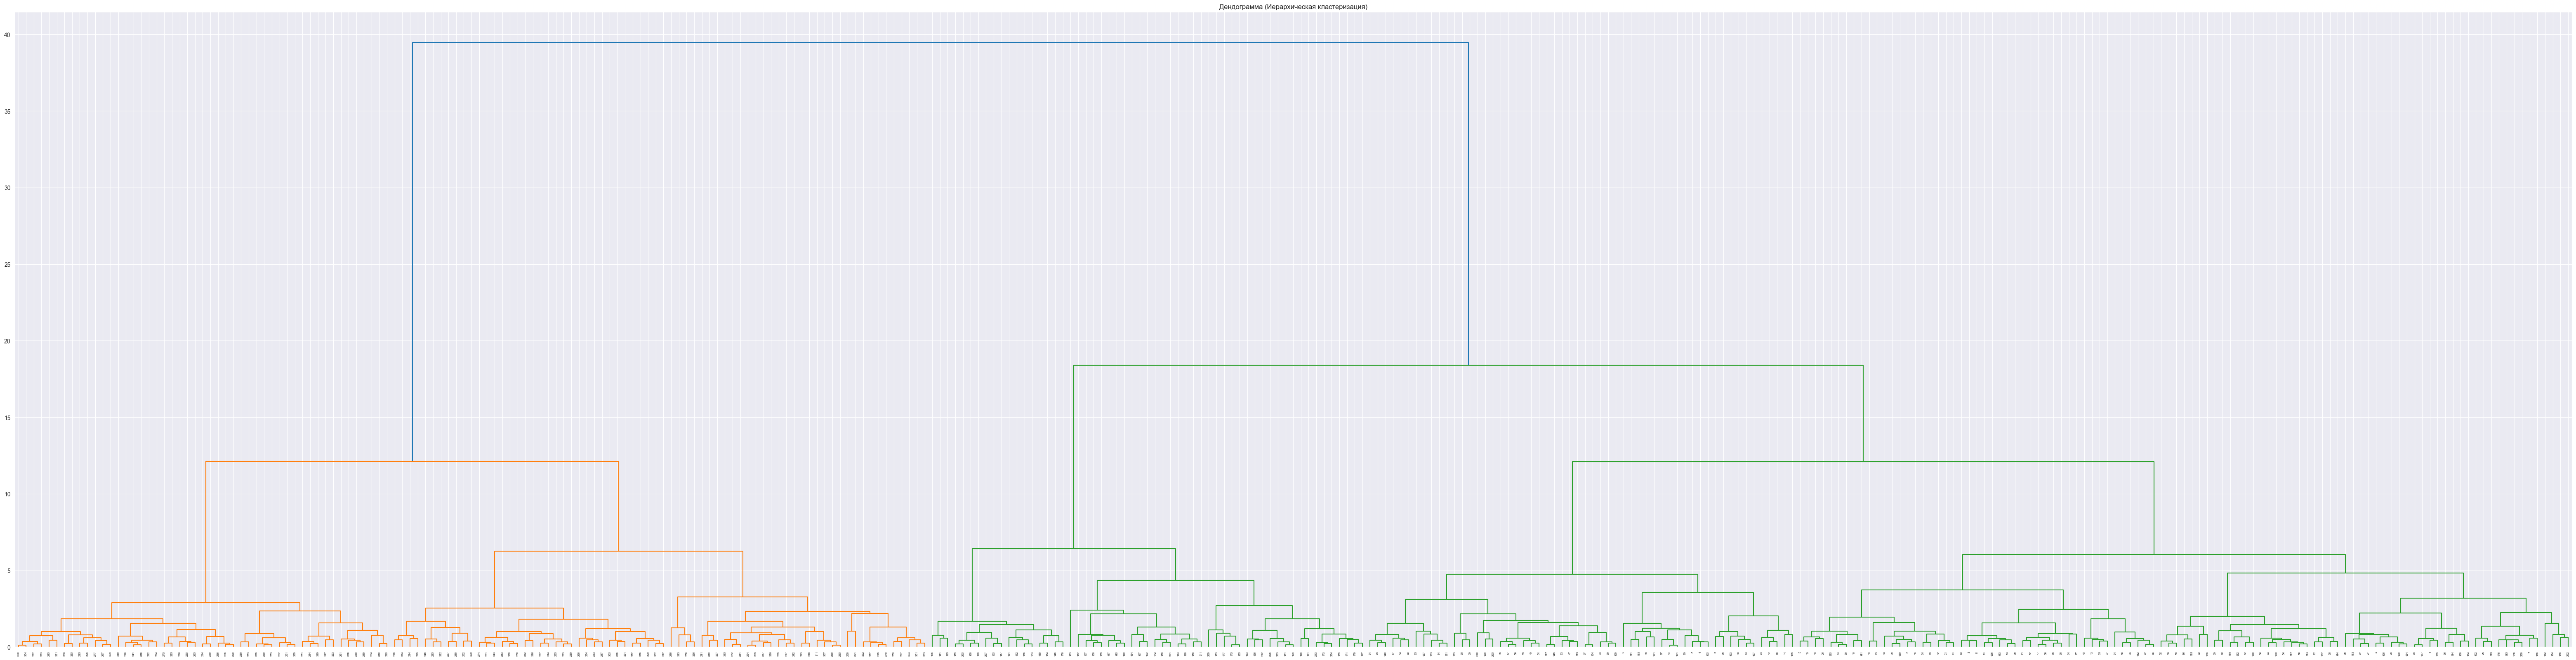

In [114]:
Z = linkage(X, method='ward')
plt.figure(figsize=(6, 4))
plt.figure(figsize=(80, 20))
dendrogram(Z)
plt.title("Дендограмма (Иерархическая кластеризация)")
plt.show()

### Метрики

### Davies–Bouldin index

$$
\mathrm{DB} = \frac{1}{K}\sum_{i=1}^{K} \max_{j \ne i}
\left(
\frac{S_i + S_j}{M_{ij}}
\right)
$$

где
- $S_i = \frac{1}{|C_i|}\sum_{x \in C_i} \lVert x - \mu_i \rVert$ - cреднее внутрикластерный расстояние
- $M_{ij} = \lVert \mu_i - \mu_j \rVert$ - межкластерное расстояние

In [115]:
def intracluster_wcss(X, centroids, labels):
    wcss = 0
    for i, c in enumerate(centroids):
        wcss += np.sum(np.linalg.norm(X[labels == i] - c, axis=1) ** 2)
    return wcss


def intercluster_distances(centroids):
    d = cdist(centroids, centroids)
    d[d == 0] = np.inf
    return np.min(d), np.mean(d)

In [116]:
def evaluate_model(X, labels, centroids=None, name=""):
    mask = labels != -1

    silhouette = silhouette_score(X[mask], labels[mask])
    ch = calinski_harabasz_score(X[mask], labels[mask])
    db = davies_bouldin_score(X[mask], labels[mask])

    if centroids is not None:
        intra = intracluster_wcss(X[mask], centroids, labels[mask])
        inter_min, inter_avg = intercluster_distances(centroids)
    else:
        intra, inter_min, inter_avg = None, None, None

    return [name, intra, inter_min, silhouette, ch, db]

In [117]:
results = []
results.append(evaluate_model(X, labels_km_analytical, centroids_analytical, "K-means вручную"))
results.append(evaluate_model(X, labels_km_lib, centroids_lib, "K-means (sklearn)"))
results.append(evaluate_model(X, labels_db, None, "DBSCAN"))
results.append(evaluate_model(X, labels_opt, None, "OPTICS"))
results.append(evaluate_model(X, labels_hier, None, "Метод Уорда"))

df_results = pd.DataFrame(results, columns=[
    "Model", "Intra-cluster WCSS", "Intercluster min dist",
    "Silhouette", "Calinski-Harabasz", "Davies-Bouldin"
])

In [118]:
df_results

,Model,Intra-cluster WCSS,Intercluster min dist,Silhouette,Calinski-Harabasz,Davies-Bouldin
0,K-means вручную,370.766144,1.884190,0.446193,427.772571,0.942010
1,K-means (sklearn),370.770248,1.888047,0.447011,427.766008,0.940135
2,DBSCAN,NaN,NaN,0.428553,266.149364,0.649977
3,OPTICS,NaN,NaN,0.525163,234.174301,0.626093
4,Метод Уорда,NaN,NaN,0.452098,408.217170,0.850245


### Визуализация

In [119]:
def plot_clusters(df_original, labels, title):
    df_plot = df_original.copy()
    df_plot["cluster"] = labels
    sns.pairplot(df_plot,
                 hue="cluster",
                 vars=df_original.columns,
                 palette="tab10", )
    plt.suptitle(title, y=1.02)
    plt.show()

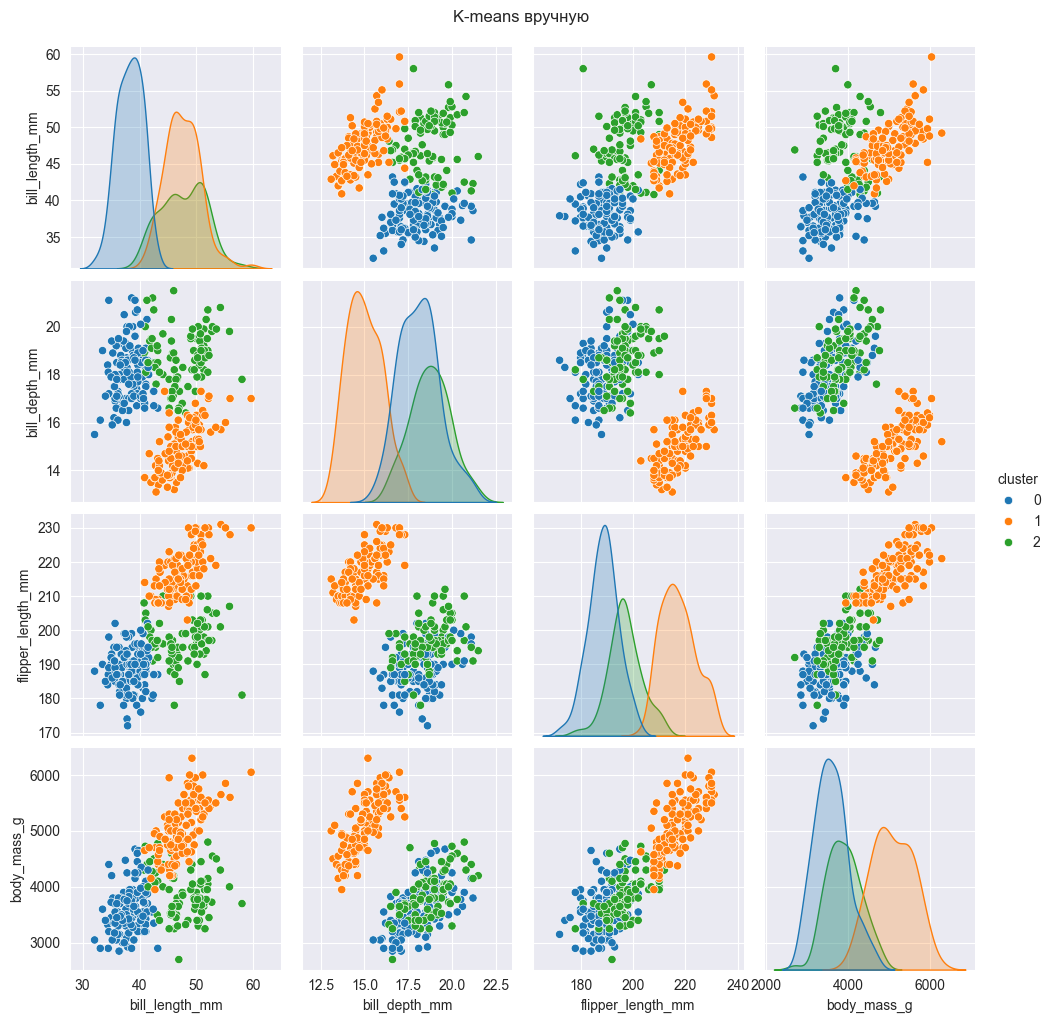

In [120]:
plot_clusters(df_num, labels_km_analytical, "K-means вручную")

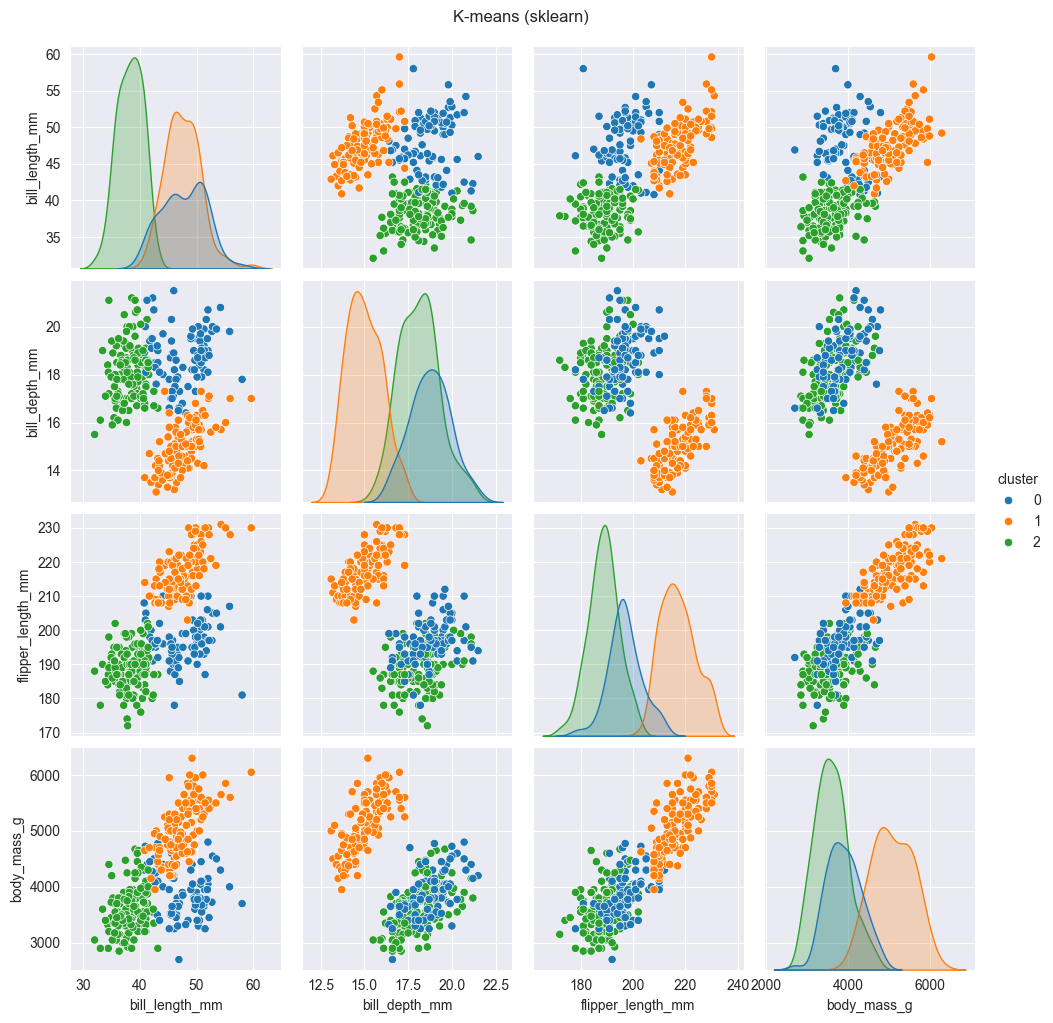

In [121]:
plot_clusters(df_num, labels_km_lib, "K-means (sklearn)")

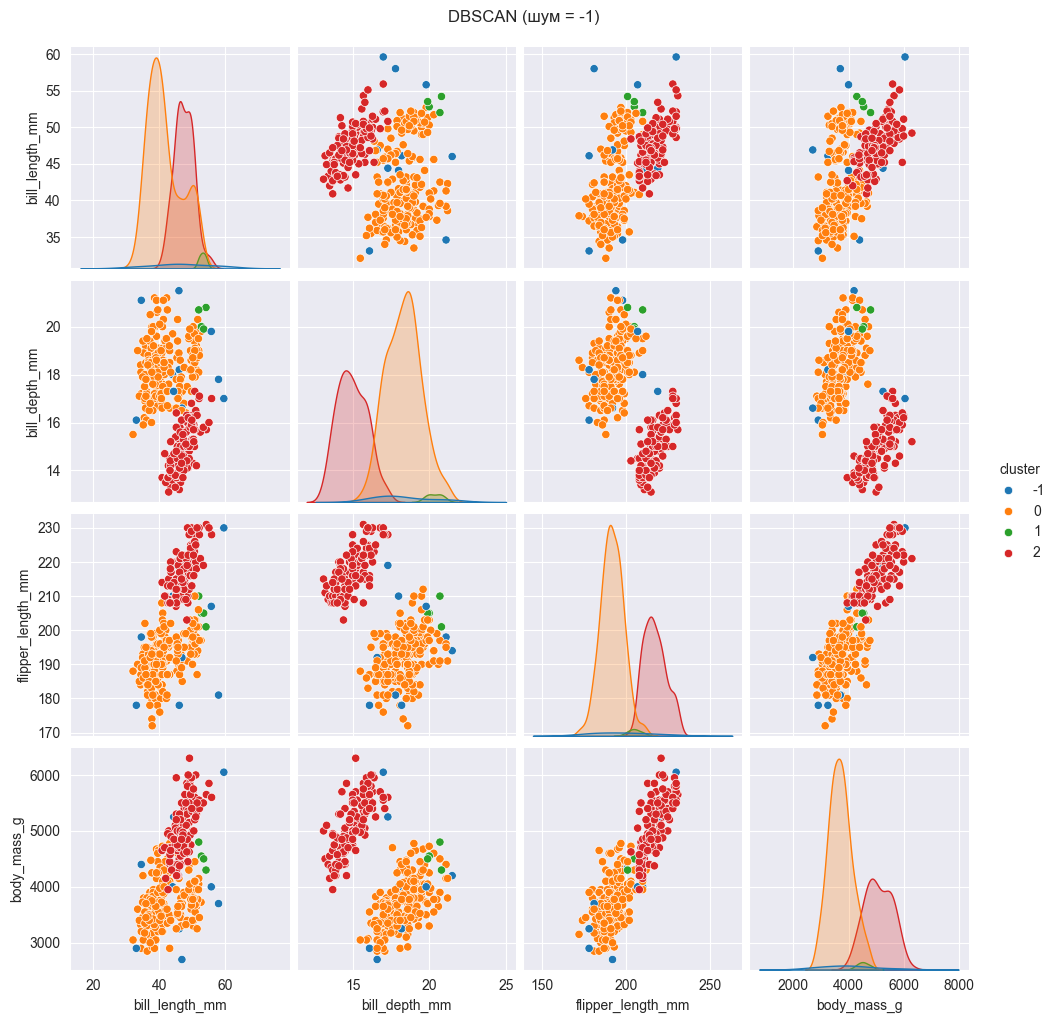

In [122]:
plot_clusters(df_num, labels_db, "DBSCAN (шум = -1)")

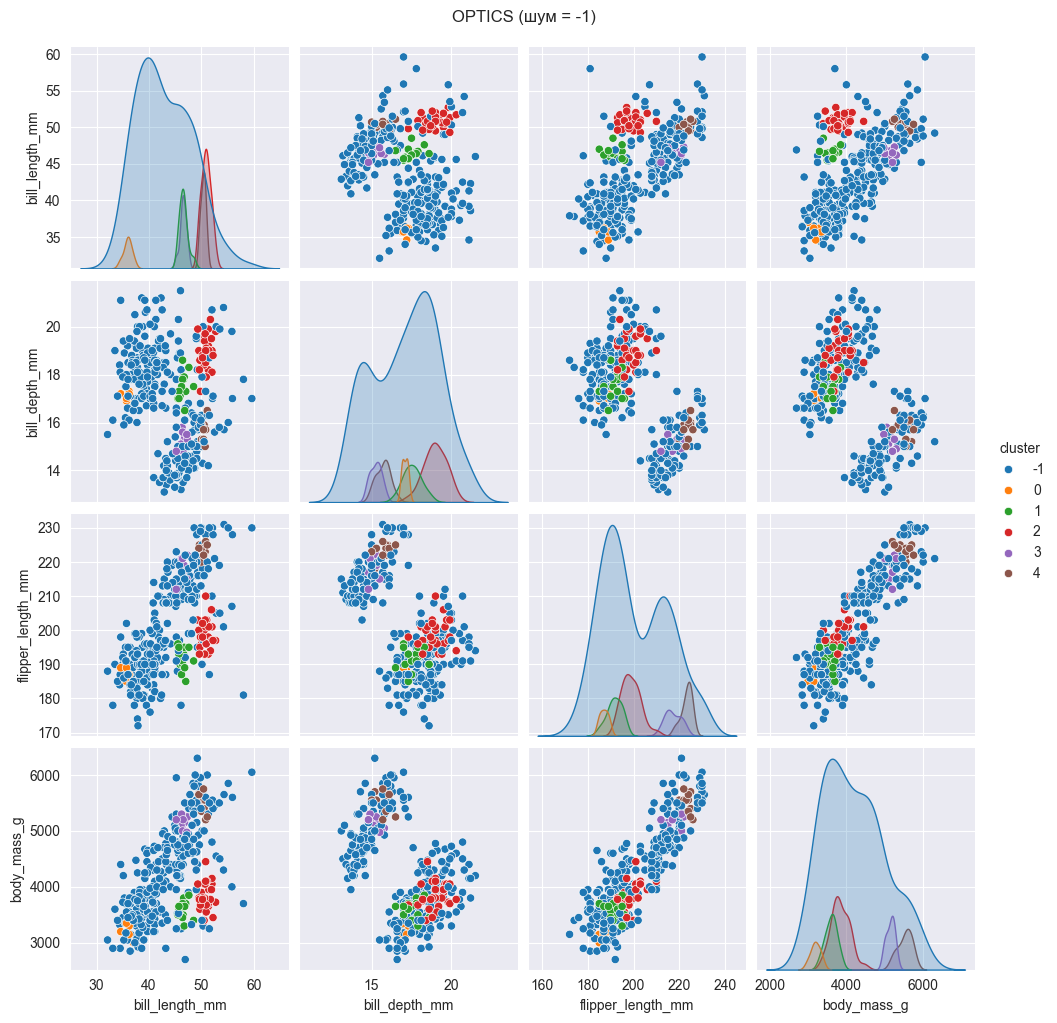

In [123]:
plot_clusters(df_num, labels_opt, "OPTICS (шум = -1)")

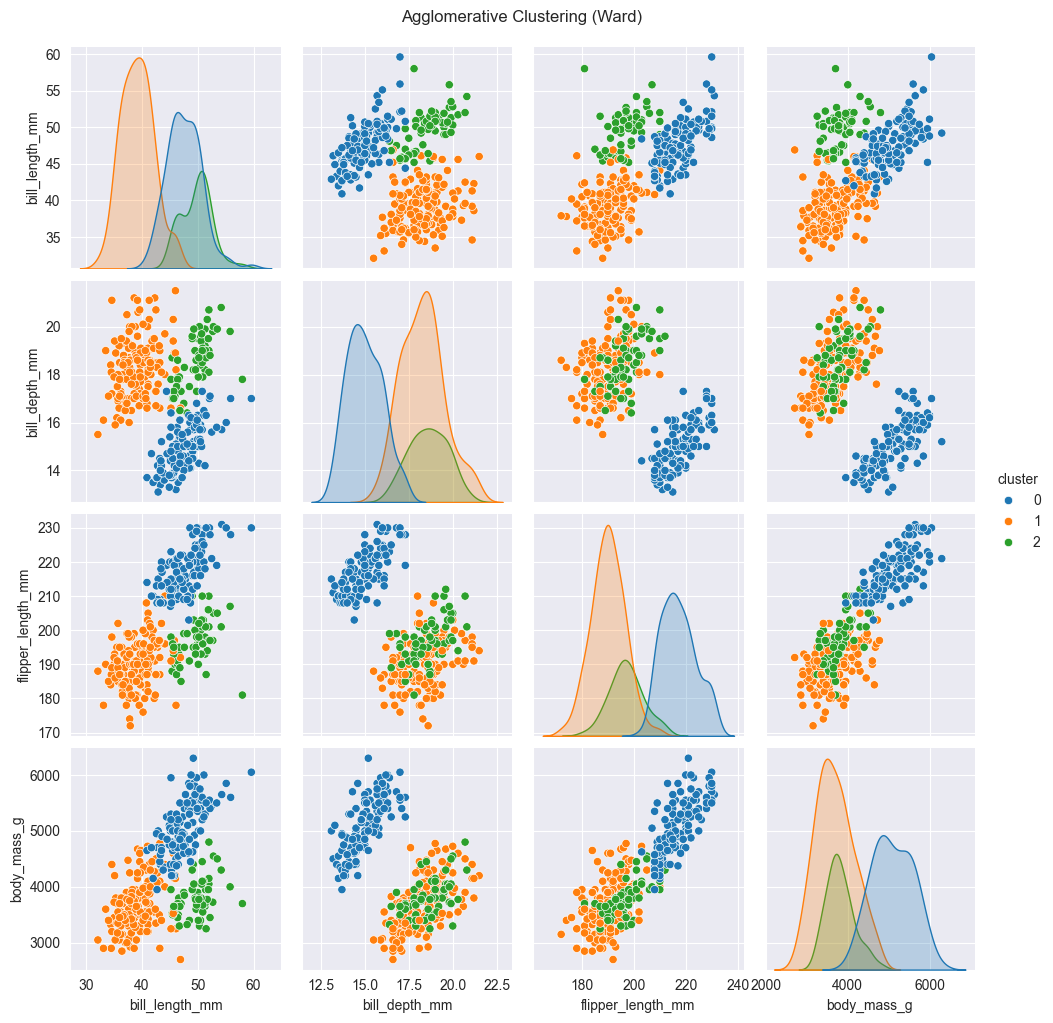

In [124]:
plot_clusters(df_num, labels_hier, "Agglomerative Clustering (Ward)")

формы k-means
dbscan